 ### TensorFlow Similarity Triplet Loss


## Notebook goal

Dataset Loading and Preprocessing:
         Load the caltech_birds2011 dataset. You can use TensorFlow Datasets (TFDS) or any other method you prefer.
         Preprocess the dataset, including resizing images to a consistent size, normalizing pixel values, and splitting it into training and test sets.

     Model Training:
         Define your SimilarityModel for training. 
         Train the model on a subset of bird species from the caltech_birds2011 dataset. You can start with a smaller number of classes to make it manageable.

     Indexing:
         Select a few examples (images) from each of the bird species classes in your training set to create the index. For example, you can index 10 images per class.
         Use the index() method of the SimilarityModel to make these examples searchable.

     Querying:
         Select some test images from the caltech_birds2011 dataset to query the model.
         Use the lookup() method of the SimilarityModel to find similar images for each query image.

     Calibration:
         Use the calibrate() method to estimate the best distance threshold for separating matching elements from elements belonging to other classes.

     Matching:
         Use the calibrated model to perform classification on the test dataset. You can use the match() method to evaluate the model's classification performance.

     Experimentation:
         Experiment with different aspects to improve the model's performance, such as adding more classes, adjusting the embedding size, using data augmentation, and increasing the number of indexed examples.

Remember to adapt the code and parameters as needed for the caltech_birds2011 dataset, including the number of classes, image dimensions, and any other dataset-specific considerations.

In [1]:
import gc
import os

import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split


# INFO messages are not printed
# This must be run before loading other modules
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds

/home/sisaai/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    ! pip install tensorflow_similarity
    import tensorflow_similarity as tfsim
import tensorflow_similarity.visualization as tfsim_visualization
import tensorflow_similarity.losses as tfsim_losses

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [4]:
tfsim.utils.tf_cap_memory()

In [5]:
# Clear out any old model state
gc.collect()
tf.keras.backend.clear_session()

In [6]:
print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.9.1
TensorFlow Similarity 0.17.1


In [7]:
tfds.list_builders()

2023-09-27 06:35:09.949351: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'ble_wind_field',
 'blimp',
 'booksum',
 'bool_q',
 'bot_adversarial_dialogue',
 'bucc',
 'c4',
 'c4_wsrs',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar100_n',
 'cifar10_1',
 'cifar10_corrupted',
 'cifar10_h',
 'cifar10_n',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'conll2002',
 

In [8]:
(training_set, validation_set), dataset_info = tfds.load(
    'caltech_birds2011',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

In [9]:
dataset_info

tfds.core.DatasetInfo(
    name='caltech_birds2011',
    full_name='caltech_birds2011/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_dir='/home/sisaai/tensorflow_datasets/caltech_birds2011/0.1.1',
    file_format=tfrecord,
    download_size=1.11 GiB,
    dataset_size=1.11 GiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=200),
        'label_name': Text(shape=(), dtype=string),
        'se

In [10]:
training_set

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
validation_set

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
num_classes = dataset_info.features['label'].num_classes
print(num_classes)

200


In [13]:
num_training_examples = 0
num_validation_examples = 0
for example in training_set:
    num_training_examples += 1
for example in validation_set:
    num_validation_examples += 1
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 200
Total Number of Training Images: 4196
Total Number of Validation Images: 1798 



In [14]:
for i, example in enumerate(training_set.take(5)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 1
Image 2 shape: (290, 500, 3) label: 149
Image 3 shape: (500, 402, 3) label: 134
Image 4 shape: (333, 500, 3) label: 171
Image 5 shape: (333, 500, 3) label: 50


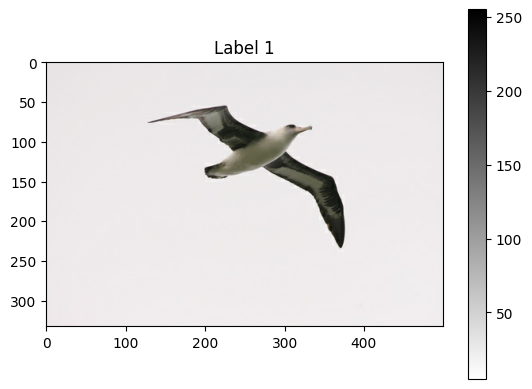

In [15]:
# Plot 1 image from the training set.
for image, label in training_set.take(1):
    break
image = image.numpy()
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('Label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.show()

In [16]:
IMAGE_RES = 32
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label
BATCH_SIZE = 32
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)
print(train_batches)
print(validation_batches)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [17]:
x_train = []
y_train = []
for images, labels in train_batches:
    x_train.append(images)
    y_train.append(labels)

# Concatenate the batches to get the complete x_train and y_train
x_train = tf.concat(x_train, axis=0)
y_train = tf.concat(y_train, axis=0)

# Optionally, shuffle the training data
# x_train, y_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(BATCH_SIZE)

# Print the shape of x_train and the number of classes
print("x_train shape:", x_train.shape)
print("Number of classes:", dataset_info.features['label'].num_classes)

x_train shape: (4196, 32, 32, 3)
Number of classes: 200


In [18]:
x_test = []
y_test = []

for images, labels in validation_batches:  # Varsayılan olarak test verilerini kullanıyoruz, bu nedenle validation_batches kullanabilirsiniz.
    x_test.append(images)
    y_test.append(labels)

# Concatenate the batches to get the complete x_test and y_test
x_test = tf.concat(x_test, axis=0)
y_test = tf.concat(y_test, axis=0)

# Optionally, shuffle the test data
# x_test, y_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(len(x_test)).batch(BATCH_SIZE)

# Print the shape of x_test
print("x_test shape:", x_test.shape)

x_test shape: (1798, 32, 32, 3)


## Triplet Loss

Triplet Loss was first introduced in FaceNet: A Unified Embedding for Face Recognition and Clustering in 2015, and it has been one of the most popular loss functions for supervised similarity or metric learning ever since. In its simplest explanation, Triplet Loss encourages that dissimilar pairs be distant from any similar pairs by at least a certain margin value. 

In [19]:
def triplet_loss(embeddings, labels):
  """Calculates the triplet loss.
  Args:
    embeddings: A tensor of shape (batch_size, embedding_size).
    labels: A tensor of shape (batch_size,).
  Returns:
    A scalar tensor representing the triplet loss.
  """
  # Step 1: Compute the pairwise distance matrix.
  distance_matrix = tfsim.losses.pairwise_distance(embeddings, embeddings)
  # Step 2: Compute the triplet loss.
  loss = tfsim.losses.TripletLoss(distance_matrix, labels)
  return loss

## Invalid triplet masking

We can apply broadcasting to enumerate distance differences for all possible triplets and represent them in a tensor of shape (batch_size, batch_size, batch_size). However, only a subset of these n^3 triplets are actually valid, and we need a corresponding mask to compute the loss value correctly. We will implement such a helper function in three steps:

    Compute a mask for distinct indices, e.g., (i != j and j != k).
    Compute a mask for valid anchor-positive-negative triplets, e.g., labels[i] == labels[j] and labels[j] != labels[k].
    Combine two masks.

In [20]:
def get_triplet_mask(labels):
  """compute a mask for valid triplets
  Args:
    labels: Batch of integer labels. shape: (batch_size,)
  Returns:
    Mask tensor to indicate which triplets are actually valid. Shape: (batch_size, batch_size, batch_size)
    A triplet is valid if:
    `labels[i] == labels[j] and labels[i] != labels[k]`
    and `i`, `j`, `k` are different.
  """
  # step 1 - get a mask for distinct indices
  # shape: (batch_size, batch_size)
  indices_equal = tf.eye(tf.shape(labels)[0], dtype=tf.bool)
  indices_not_equal = tf.logical_not(indices_equal)
  # shape: (batch_size, batch_size, 1)
  i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
  # shape: (batch_size, 1, batch_size)
  i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
  # shape: (1, batch_size, batch_size)
  j_not_equal_k = tf.expand_dims(indices_not_equal, 0)
  # Shape: (batch_size, batch_size, batch_size)
  distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)
  # step 2 - get a mask for valid anchor-positive-negative triplets
  # shape: (batch_size, batch_size)
  labels_equal = tf.expand_dims(labels, 0) == tf.expand_dims(labels, 1)
  # shape: (batch_size, 1, batch_size)
  i_equal_j = tf.expand_dims(labels_equal, 1)
  # shape: (batch_size, batch_size, 1)
  i_equal_k = tf.expand_dims(labels_equal, 2)
  valid_indices = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

  mask = tf.logical_and(distinct_indices, valid_indices)

  return mask

## Batch-all strategy for online triplet mining

Triplet Loss involves several strategies to form or select triplets, and the simplest one is to use all valid triplets that can be formed from samples in a batch. This can be achieved in four easy steps thanks to utility functions we’ve already implemented:

    Get a distance matrix of all possible pairs that can be formed from embeddings in a batch.
    Apply broadcasting to this matrix to compute loss values for all possible triplets.
    Set loss values of invalid or easy triplets to 0.
    Average the remaining positive values to return a scalar loss.

In [21]:
class BatchAllTripletLoss(tf.keras.losses.Loss):
  def __init__(self, margin=1.0):
    super(BatchAllTripletLoss, self).__init__()
    self.margin = margin
  def call(self, y_true, y_pred):
    """Computes the triplet loss.
    Args:
      y_true: A tensor of shape (batch_size, num_classes).
      y_pred: A tensor of shape (batch_size, embedding_dim).
    Returns:
      A scalar tensor representing the triplet loss.
    """
    # Step 1: Get distance matrix.
    distance_matrix = tf.reduce_sum(
        tf.square(y_pred - tf.expand_dims(y_pred, 1)), axis=2)
    # Step 2: Compute loss values for all triplets by applying broadcasting to distance matrix.
    anchor_positive_dists = tf.expand_dims(distance_matrix, 2)
    anchor_negative_dists = tf.expand_dims(distance_matrix, 1)
    triplet_loss = anchor_positive_dists - anchor_negative_dists + self.margin
    # Step 3: Filter out invalid or easy triplets by setting their loss values to 0.
    mask = get_triplet_mask(y_true)
    triplet_loss *= mask
    triplet_loss = tf.nn.relu(triplet_loss)
    # Step 4: Compute scalar loss value by averaging positive losses.
    num_positive_losses = tf.reduce_sum(tf.cast(triplet_loss > 0, tf.float32))
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_losses + 1e-8)
    return triplet_loss


### Model definition

`SimilarityModel()` models extend `tensorflow.keras.model.Model` with additional features and functionality that allow you to index and search for similar looking examples.

In [22]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1 / 255)(inputs)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(128, 3, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    # smaller embeddings will have faster lookup times while a larger embedding will improve the accuracy up to a point.
    outputs = tfsim.layers.MetricEmbedding(128)(x)
    return tfsim.models.SimilarityModel(inputs, outputs)

In [23]:
model = create_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                  

## Loss Definition

In [24]:
distance = "cosine"  # @param ["cosine", "L2", "L1"]{allow-input: false}
loss = tfsim_losses.TripletLoss(distance=distance)

### Compilation

Tensorflow similarity use an extended `compile()` method that allows you to optionally specify `distance_metrics` (metrics that are computed over the distance between the embeddings), and the distance to use for the indexer.

By default the `compile()` method tries to infer what type of distance you are using by looking at the first loss specified. If you use multiple losses, and the distance loss is not the first one, then you need to specify the distance function used as `distance=` parameter in the compile function.

In [25]:
LR = 0.00005  # @param {type:"number"}
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss=loss, metrics=['accuracy'])

Distance metric automatically set to cosine use the distance arg to override.


## Training
Similarity models are trained like normal models. 


In [26]:
EPOCHS = 50  # @param {type:"integer"}
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)


Epoch 1/50


2023-09-27 06:35:20.296151: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


132/132 [==============================] - 7s 18ms/step - loss: 0.4743 - accuracy: 0.0045 - val_loss: 0.4748 - val_accuracy: 0.0028
Epoch 2/50
132/132 [==============================] - 2s 13ms/step - loss: 0.4580 - accuracy: 0.0048 - val_loss: 0.4520 - val_accuracy: 0.0044
Epoch 3/50
132/132 [==============================] - 2s 13ms/step - loss: 0.4475 - accuracy: 0.0048 - val_loss: 0.4591 - val_accuracy: 0.0100
Epoch 4/50
132/132 [==============================] - 2s 13ms/step - loss: 0.4429 - accuracy: 0.0055 - val_loss: 0.4457 - val_accuracy: 0.0044
Epoch 5/50
132/132 [==============================] - 2s 14ms/step - loss: 0.4486 - accuracy: 0.0033 - val_loss: 0.4487 - val_accuracy: 0.0050
Epoch 6/50
132/132 [==============================] - 2s 16ms/step - loss: 0.4418 - accuracy: 0.0048 - val_loss: 0.4446 - val_accuracy: 0.0056
Epoch 7/50
132/132 [==============================] - 2s 16ms/step - loss: 0.4422 - accuracy: 0.0052 - val_loss: 0.4452 - val_accuracy: 0.0067
Epoch 8/50

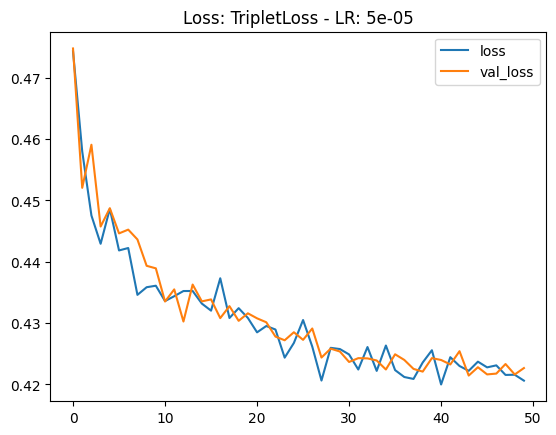

In [27]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name} - LR: {LR}")
plt.show()

## Indexing

Indexing is where things get different from traditional classification models. Because the model learned to output an embedding that represent the example position within the learned metric space, we need a way to find which known example(s) are the closest to determine the class of the query example (aka nearest neighbors classication).

To do so, we are creating an index of known examples from all the classes present in the dataset. We do this by taking a total of 200 examples from the train dataset which amount to 20 examples per class and we use the index() method of the model to build the index.

In [28]:
class_list = list(range(20))  # List of class labels from 0 to 19
x_index, y_index = tfsim.samplers.select_examples(x_train, y_train, class_list, num_examples_per_class=20)
model.reset_index()
model.index(x_index, y_index, data=x_index)

gather examples: 100%|██████████| 400/400 [00:00<00:00, 2973.83it/s]


[Indexing 400 points]
|-Computing embeddings
13/13 [==============================] - 0s 8ms/step
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.



0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


## Querying

To "classify" examples, we need to lookup their *k* [nearest neighbors](https://scikit-learn.org/stable/modules/neighbors.html) in the index.

Here we going to query a single random example for each class from the test dataset using `select_examples()` and then find their nearest neighbors using the `lookup()` function.

gather examples: 100%|██████████| 20/20 [00:00<00:00, 1508.01it/s]

1/1 [==============================] - 0s 65ms/step



Performing NN search



Building NN list: 100%|██████████| 20/20 [00:00<00:00, 24470.85it/s]


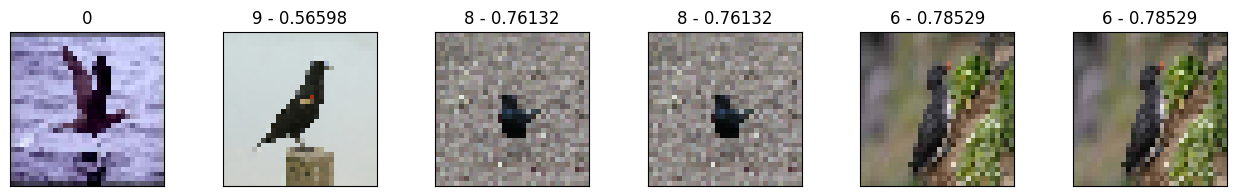

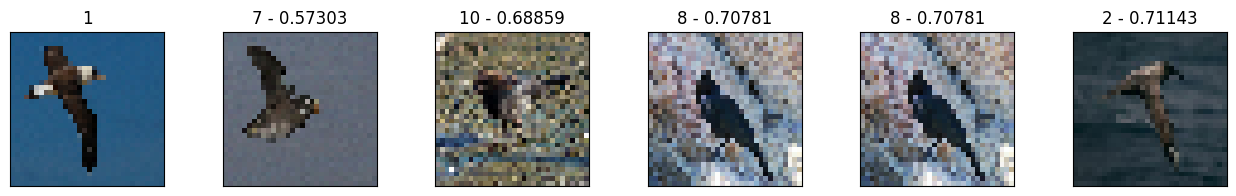

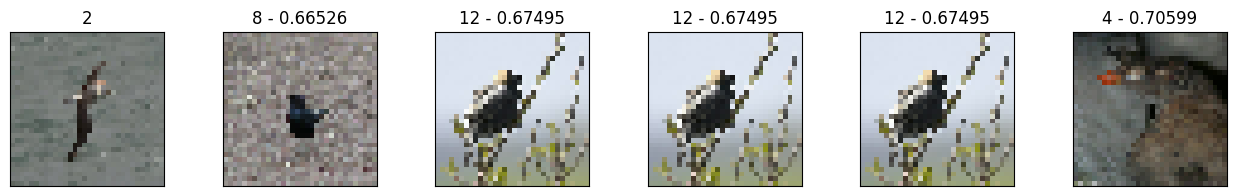

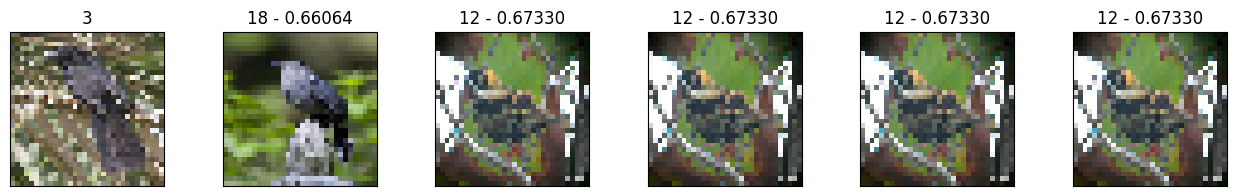

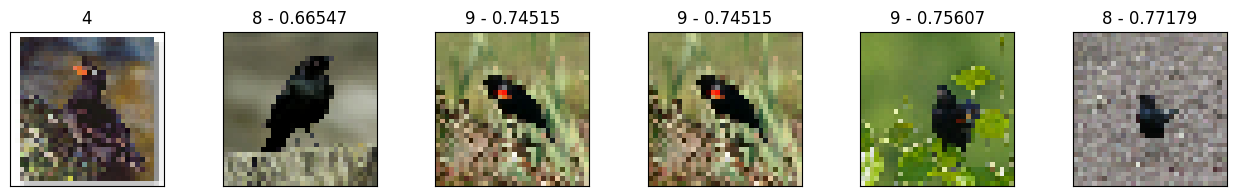

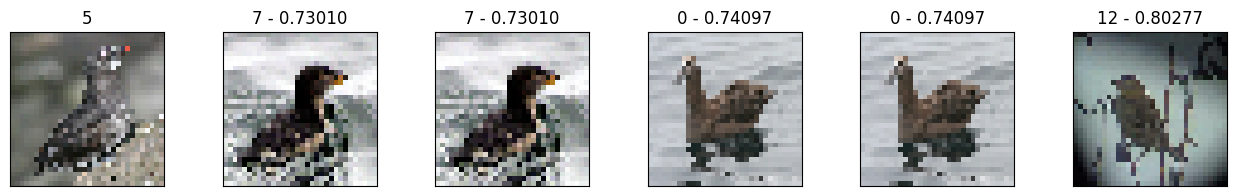

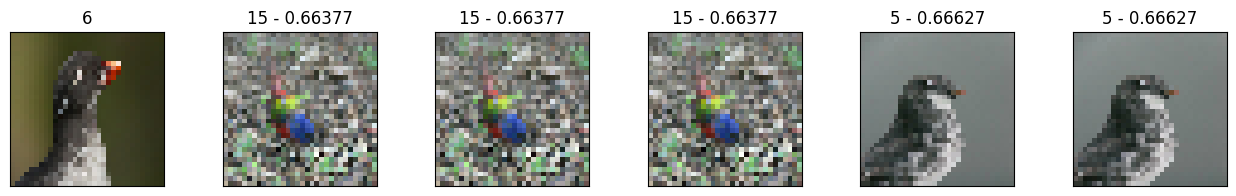

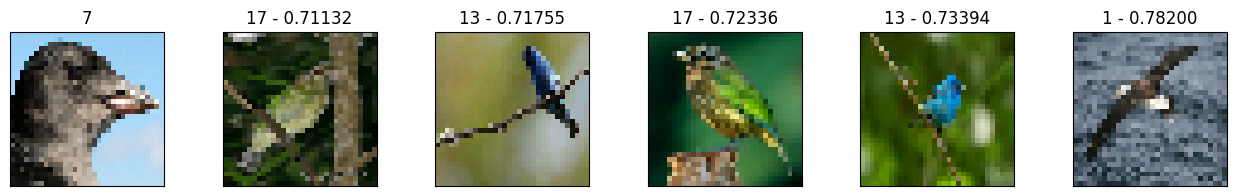

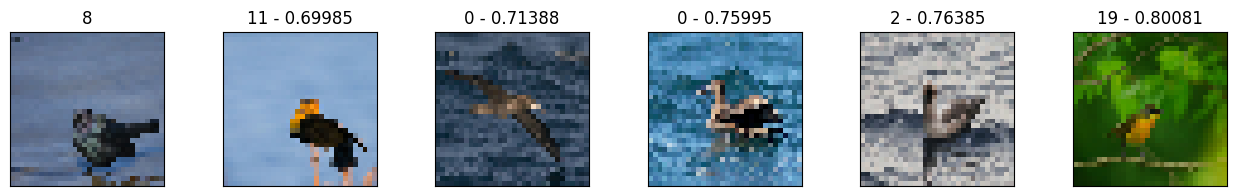

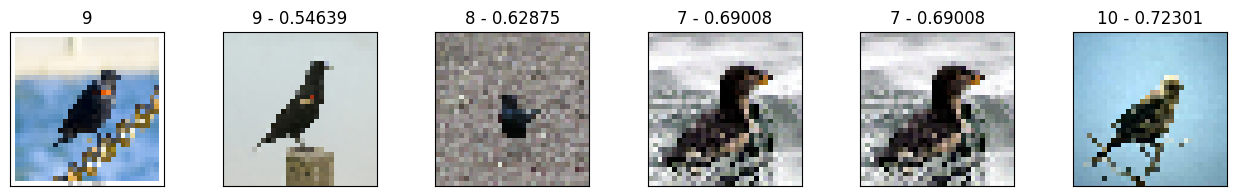

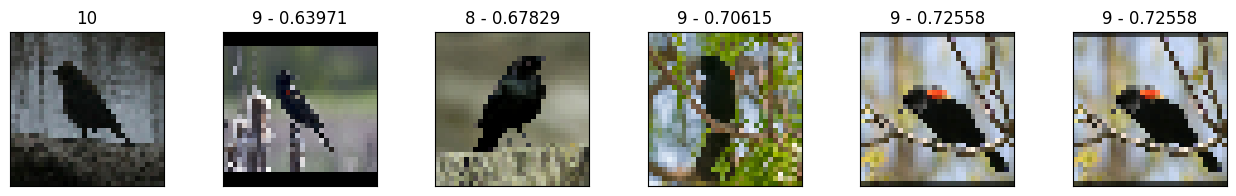

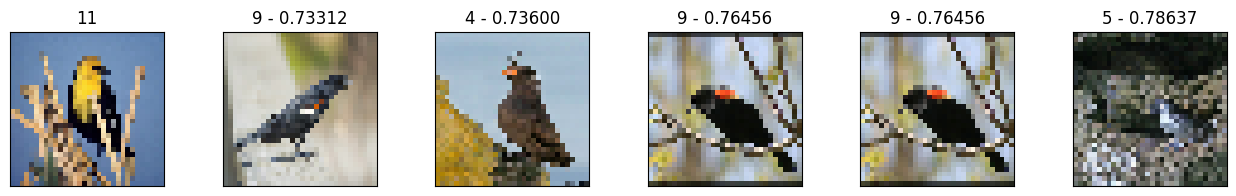

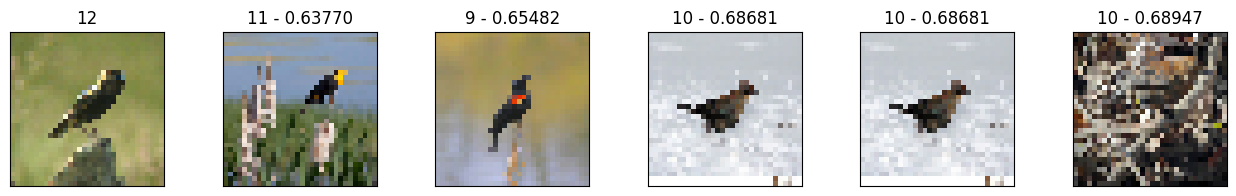

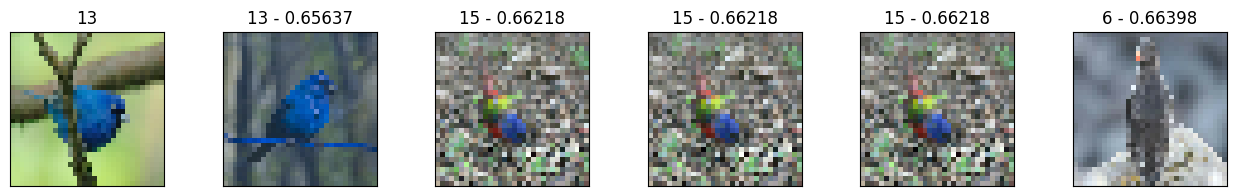

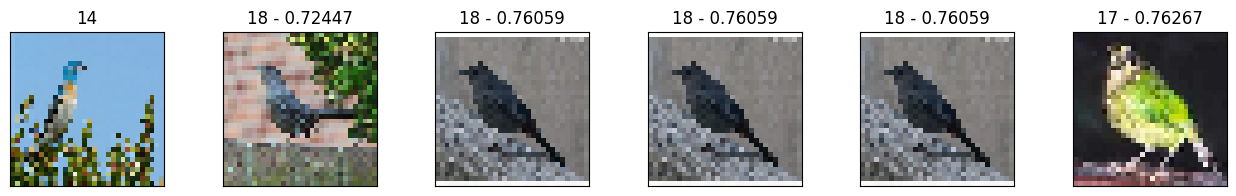

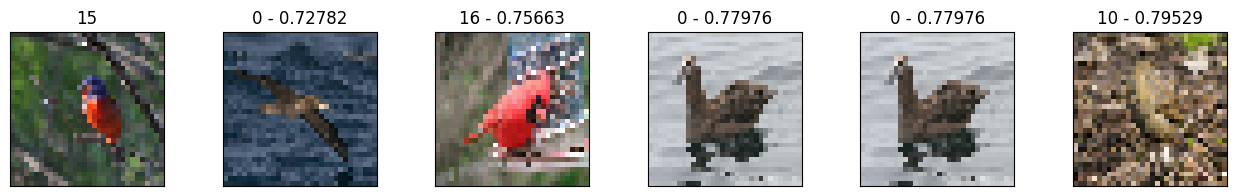

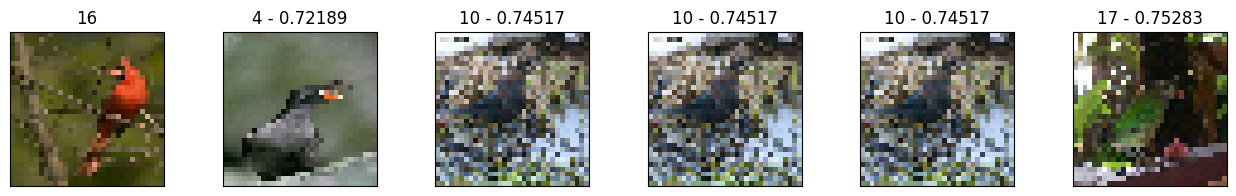

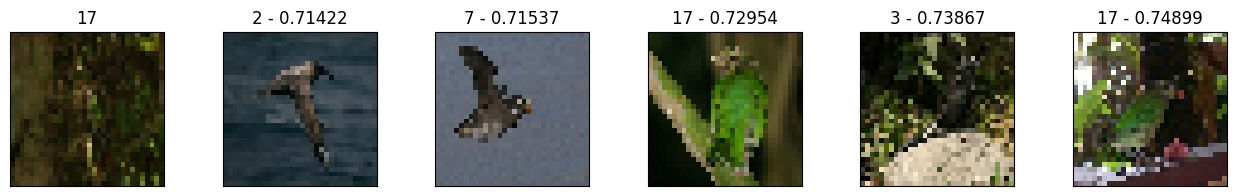

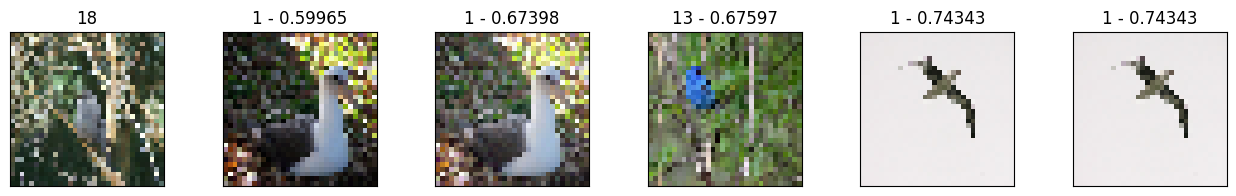

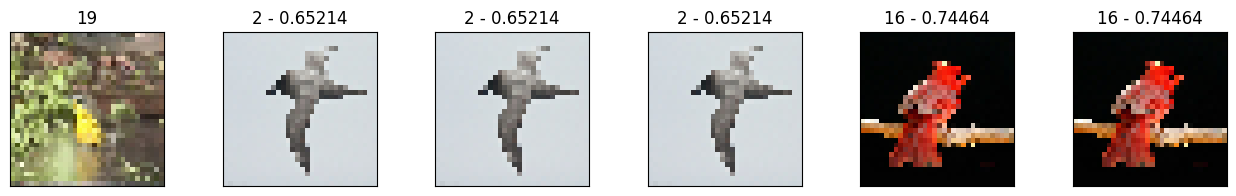

In [29]:
# re-run to test on other examples
num_neighbors = 5

# select
x_display, y_display = tfsim.samplers.select_examples(x_test, y_test, class_list, 1)

# lookup nearest neighbors in the index
nns = model.lookup(x_display, k=num_neighbors)

# display
for idx in np.argsort(y_display):
    tfsim_visualization.viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], fig_size=(16, 2), cmap="Greys")

## Calibration

To be able to tell if an example matches a given class, we first need to `calibrate()` the model to find the optimal cut point. This cut point is the maximum distance below which returned neighbors are of the same class. Increasing the threshold improves the recall at the expense of the precision.

By default, the calibration uses the F-score classification metric to optimally balance out the precsion and recalll; however, you can speficy your own target and change the calibration metric to better suite your usecase.

In [30]:
num_calibration_samples = 1000
calibration = model.calibrate(
    x_train[:num_calibration_samples],
    y_train[:num_calibration_samples],
    extra_metrics=["precision", "recall", "binary_accuracy"],
    verbose=1,
)

32/32 [==============================] - 0s 6ms/step

Performing NN search



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 1151.81it/s]


 name        value    distance    precision    recall    binary_accuracy        f1
-------  --------  ----------  -----------  --------  -----------------  --------
optimal  0.965517       3e-07            1  0.933333              0.056  0.965517


## Metrics ploting

Let's plot the performance metrics to see how they evolve as the distance threshold increases. 

We clearly see an inflection point where the precision and recall intersect, however, this is not the `optimal_cutpoint` because the recall continues to increase faster than the precision decreases. Different usecases will have different performance profiles, which why each model needs to be calibrated.

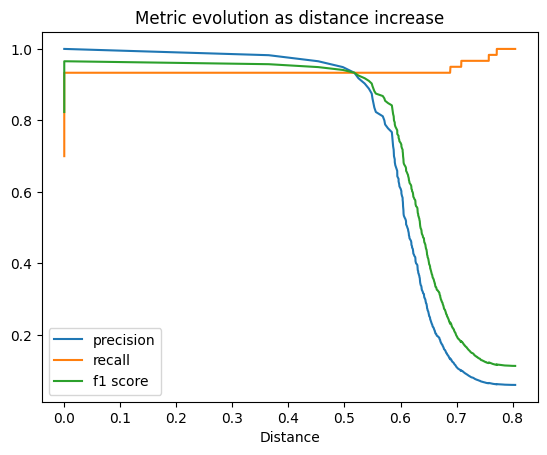

In [31]:
fig, ax = plt.subplots()
x = calibration.thresholds["distance"]
ax.plot(x, calibration.thresholds["precision"], label="precision")
ax.plot(x, calibration.thresholds["recall"], label="recall")
ax.plot(x, calibration.thresholds["f1"], label="f1 score")
ax.legend()
ax.set_title("Metric evolution as distance increase")
ax.set_xlabel("Distance")
plt.show()

### Precision/Recall curve

We can see in the precision/recall curve below, that the curve is not smooth.This is because the recall can improve independently of the precision causing a seesaw pattern.

Additionally, the model does extremly well on known classes and less well on the unseen ones, which contributes to the flat curve at the begining followed by a sharp decline as the distance threshold increases and examples are further away from the indexed examples.

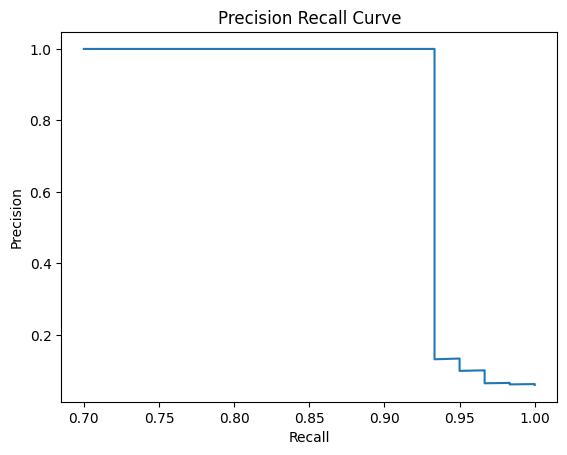

In [32]:
fig, ax = plt.subplots()
ax.plot(calibration.thresholds["recall"], calibration.thresholds["precision"])
ax.set_title("Precision Recall Curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
plt.show()

## Matching

The purpose of `match()` is to allow you to use your similarity models to make classification predictions. It accomplishes this by finding the nearest neigbors for a set of query examples and returning an infered label based on neighbors labels and the matching strategy used (MatchNearest by default).

Note: unlike traditional models, the  `match()` method potentially returns -1 when there are no indexed examples below the cutpoint threshold. The -1 class should be treated as "unknown".

In [33]:
from tabulate import tabulate
num_matches = 10  # @param {type:"integer"}

# Make predictions on the test data
predictions = model.predict(x_test[:num_matches])

# Create a list to store the results
rows = []

# Compare the predicted labels to the expected labels
for idx in range(num_matches):
    predicted_label = int(tf.argmax(predictions[idx]).numpy())
    expected_label = int(y_test[idx])

    # Check if the prediction is correct
    correct = predicted_label == expected_label

    rows.append([predicted_label, expected_label, correct])

# Print the results using tabulate
print(tabulate(rows, headers=["Predicted", "Expected", "Correct"]))

1/1 [==============================] - 0s 55ms/step
  Predicted    Expected  Correct
-----------  ----------  ---------
         28          64  False
        104         122  False
          0         122  False
         28          72  False
         79         131  False
          3          79  False
         67           0  False
         12          91  False
         15         146  False
        114         194  False


### Confusion Matrix
Now that we have a better sense of what the match() method does, let's scale up to a few thousand samples per class and evaluate how good our model is at predicting the correct classes.

As expected, while the model prediction performance is very good, its not competitive with a classification model. However this lower accuracy comes with the unique advantage that the model is able to classify classes that were not seen during training.


**NOTE** `tf.math.confusion_matrix` doesn't support negative classes, so we are going to use **class 10 as our unknown class**. As mentioned earlier, unknown examples are  any testing example for which the closest neighbor distance is greater than the cutpoint threshold.

gather examples: 100%|██████████| 20000/20000 [00:06<00:00, 3321.75it/s]


625/625 [==============================] - 3s 5ms/step


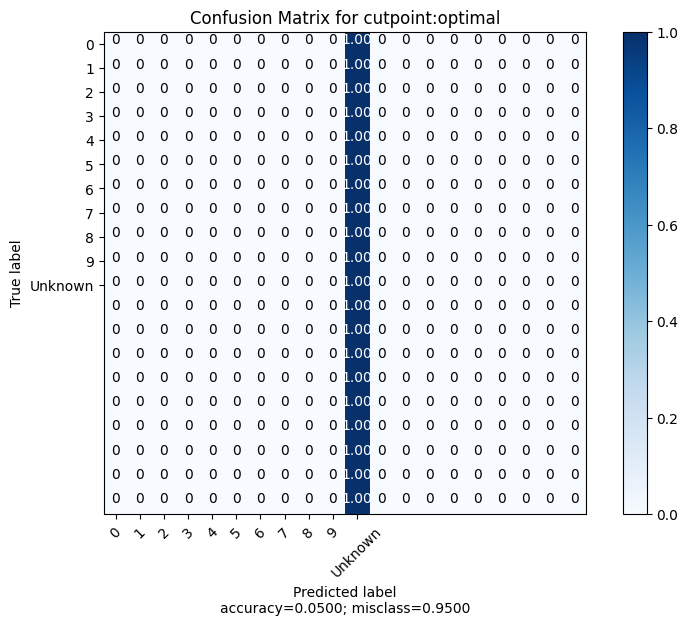

In [34]:
# used to label in images in the viz_neighbors_imgs plots
# note we added a 11th classes for unknown
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "Unknown"]
num_examples_per_class = 1000
cutpoint = "optimal"

x_confusion, y_confusion = tfsim.samplers.select_examples(x_test, y_test, class_list, num_examples_per_class)

matches = model.match(x_confusion, cutpoint=cutpoint, no_match_label=10)
cm = tfsim_visualization.confusion_matrix(
    matches,
    y_confusion,
    labels=labels,
    title="Confusion Matrix for cutpoint:%s" % cutpoint,
)

### Index information

Following `model.summary()` you can get information about the index configuration and its performance using `index_summary()`.

In [35]:
model.index_summary()

[Info]
------------------  ------
distance            cosine
key value store     memory
search algorithm    nmslib
evaluator           memory
index size          400
calibrated          True
calibration_metric  f1
embedding_output
------------------  ------



[Performance]
-----------  ---------------
num lookups  21020
min              2.51799e-05
max              2.51799e-05
avg              2.51799e-05
median           2.51799e-05
stddev           3.38813e-21
-----------  ---------------
